# Introduction

This work is greatly inspired by the article [Entangling logical qubits with lattice surgery](https://www.nature.com/articles/s41586-020-03079-6), preprint available [here](https://arxiv.org/abs/2006.03071) by A.Erhard, H.P.Nautrup, M.Meth, L.Postler, R.Stricker, M.Ringbauer, P.Schindler, H.J.Briegel, R.Blatt, N.Friis and T.Monz.
While I don't have a link with this group, I was amazed that it was already possible to implement logical qubits with current quantum computers. 

This notebook aims to reproduce some results of this great work to gain better understanding. It consists of presenting the single logical qubit encoding, explaining the interest with regards to error detection and correction, and finally two-qubits operation for capability demonstrations.

It is recommanded to not "Run all" cells, as the azure jobs would be relaunched, and results overwritten and will take a long time to recompute. Otherwise, cells defining operation that are simulated locally can be modified and re-executed of course.

# Azure connection

In [1]:
import qsharp.azure
targets = qsharp.azure.connect(
   resourceId="/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
   location="eastus")

Connected to Azure Quantum workspace qchack-2022-b in location eastus.


In [34]:
import qsharp

print("This workspace's targets:")
for target in targets:
    print("-", target.id)

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt


# State preparation and manipulation

## Enconding the state

We will encode our logical qubit into a matrix of 2X2 qubits: this code is part of the surface code family. Thanks to the full connectivity of the ion-trap processors, we have no restrictions on which physical qubits can be directly coupled, we will implement this surface code while keeping in mind that the qubits are not really bound to such lattice.
The logical states will be : 
$|0_L\rangle=(|0101\rangle+|1010\rangle)/\sqrt{2}$
and
$|1_L\rangle=(|1001\rangle+|0110\rangle)/\sqrt{2}$

Let's write operations to prepare these two states:

In [35]:
%%qsharp
open Microsoft.Quantum.Diagnostics;
open Microsoft.Quantum.Math;

operation PrepareZero_L (qs : Qubit[]) : Unit is Adj+Ctl {
    //Only MS gates? I'll use CNOT for now
    H(qs[0]);
    CNOT(qs[0], qs[2]);
    X(qs[0]);
    CNOT(qs[0], qs[1]);
    CNOT(qs[0], qs[3]);
    X(qs[0]);
}

operation PrepareOne_L (qs : Qubit[]) : Unit is Adj+Ctl {
    H(qs[0]);
    CNOT(qs[0], qs[3]);
    X(qs[0]);
    CNOT(qs[0], qs[1]);
    CNOT(qs[0], qs[2]);
    X(qs[0]);
}

We will now use visualization tools of Q# to check our generated states

In [36]:
%%qsharp

operation ZeroTest() : Unit {
    use qs = Qubit[4];
    PrepareZero_L(qs);
    DumpMachine();
    ResetAll(qs);
}

operation OneTest() : Unit {
    use qs = Qubit[4];
    PrepareOne_L(qs);
    DumpMachine();
    ResetAll(qs);
}

In [37]:
config = qsharp.config
config["dump.basisStateLabelingConvention"] = "Bitstring"
config["dump.truncateSmallAmplitudes"] = True
ZeroTest.simulate()

|0101⟩	0,7071067811865476 + 0𝑖
|1010⟩	0,7071067811865476 + 0𝑖

()

In [38]:
OneTest.simulate()

|0110⟩	0,7071067811865476 + 0𝑖
|1001⟩	0,7071067811865476 + 0𝑖

()

Great! That was our goal

## Single qubit operation

In order to use our logical qubit as an actual qubit, we need to define a sufficent number of operations, in order to get an [universal set of gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Universal_quantum_gates). We will need a few single qubit gates, and at least one entangling multi-qubit gate. Like in hardware implementation, the later gate will be the hardest to implement, we will come back to it later. Here is an example of two single logical qubit gates made from single physical qubit gates:

In [7]:
%%qsharp

operation X_L (qs : Qubit[]) : Unit is Adj+Ctl {
    X(qs[0]);
    X(qs[1]);
}

operation Z_L (qs : Qubit[]) : Unit is Adj+Ctl {
    Z(qs[0]);
    Z(qs[2]);
}

In normal operation, we know the logical qubit is in either of the two state, or in a superposition of the two. If we want to measure the logical qubit to project it onto one of the two states, we don't have to measure all of its physical qubits. Indeed, looking only at the second and third qubit, we see that in $|0_L\rangle$ case, we have$(|10\rangle + |01\rangle)/\sqrt{2}$ whereas in the $|1_L\rangle$, we have$(|00\rangle + |11\rangle)/\sqrt{2}$
This means we can distinguish the two states by only doing parity measurement of the physical qubits 2 & 3. (although redundancy measurements could reduce erroneous readings!)

In [8]:
%%qsharp

operation Measure_L(qs : Qubit[]) : Result {
    let res = Measure([PauliZ, PauliZ], qs[1..2]);
    //Note the logical one state has indeed Zero result when 
    //parity is measured, and logical zero has One.
    return res == One ? Zero | One;
}

In [9]:
%%qsharp

operation MeasureTest(state : Int) : Result {
    use qs = Qubit[4];
    if state==0 {
        PrepareZero_L(qs);
    }
    else {
        PrepareOne_L(qs);
    }
    let res=Measure_L(qs);
    ResetAll(qs);
    return res;
}

In [295]:
state = 1
print(f"We generate logical state {state}, we measure it later as {MeasureTest.simulate(state=state)}")

We generate logical state 1, we measure it later as 1


You can try to insert the previously defined single qubit operations in the MeasureTest operation, after logical qubit prepartion, and see how they affect measurement!

### Experimenting with single qubit and Azure targets

We have not applied any quantum error correction yet, so the state is not so special for now. We can try to generate it on hardware available with Azure Quantum. First, let's check that our implementation is valid using IonQ's simulator.

In [297]:
%%qsharp

operation TimeWaster(q1 : Qubit, q2 : Qubit) : Unit {
    //These are arbitrarly chosen operations on two qubits to wait while
    //our actual logical qubit is decohering and decaying
    H(q1);
    CNOT(q1, q2);
    Z(q1);
    CNOT(q2, q1);
    X(q2);
}

In [299]:
%%qsharp

operation PrepareDecayMeasure() : Result {
    use qs = Qubit[4];
    use waitingQubits = Qubit[2];
    PrepareOne_L(qs);
    for _ in 1..100 {
        TimeWaster(waitingQubits[0], waitingQubits[1]);
    }
    //Because of the "No Control Flow" limitation of IonQ, measurement
    // has to be returned right away, so we can't reuse the previously defined Measure_L operation.
    X(qs[1]); //so that One corresponds to logical one.
    return Measure([PauliZ, PauliZ], qs[1..2]);
}

#### IonQ Simulator

In [300]:
# Set the target to ionq.simulator
qsharp.azure.target("ionq.simulator")

# We'll use 100 shots (simulated runs). Timeout is in seconds.
resultSim = qsharp.azure.execute(PrepareDecayMeasure, shots=100, jobName="PrepareDecayMeasureSim", timeout=240)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.simulator
Submitting PrepareDecayMeasure to target ionq.simulator...
Job successfully submitted for 100 shots.
   Job name: PrepareDecayMeasureSim
   Job ID: a3c0bc64-4af5-40fc-b371-7b92335d593d
Waiting up to 240 seconds for Azure Quantum job to complete...
[13:14:24] Current job status: Waiting
[13:14:29] Current job status: Waiting
[13:14:34] Current job status: Waiting
[13:14:39] Current job status: Waiting
[13:14:44] Current job status: Waiting
[13:14:49] Current job status: Waiting
[13:14:55] Current job status: Succeeded


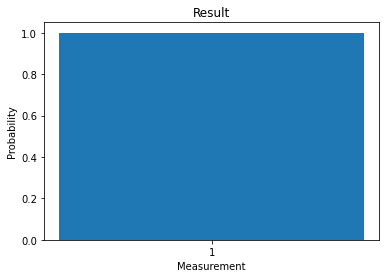

In [301]:
from matplotlib import pyplot

pyplot.bar(resultSim.keys(), resultSim.values())
pyplot.title("Result")
pyplot.xlabel("Measurement")
_ = pyplot.ylabel("Probability")

#### IonQ QPU

The code runs, let's try it on a target with actual noise : we will use the real hardware of IonQ.

I will use the submit method, and collect the result later, as Jupyter gives a Timeout Error when waiting too long:

In [302]:
# Set the target to IonQ's QPU
qsharp.azure.target("ionq.qpu")

qpu_job1 = qsharp.azure.submit(PrepareDecayMeasure, shots=100, jobName="PrepareDecayMeas", timeout=2400)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu
Submitting PrepareDecayMeasure to target ionq.qpu...
Job successfully submitted for 100 shots.
   Job name: PrepareDecayMeas
   Job ID: bc3a162b-fcc5-42eb-ac90-243cdf376ab9


In [306]:
qsharp.azure.status(qpu_job1.id)

{'id': 'bc3a162b-fcc5-42eb-ac90-243cdf376ab9', 'name': 'PrepareDecayMeas', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=bc3a162b-fcc5-42eb-ac90-243cdf376ab9', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-04-10T11:15:20.7128131+00:00', 'begin_execution_time': '2022-04-10T11:24:04.31+00:00', 'end_execution_time': '2022-04-10T11:24:11.067+00:00', 'cost_estimate': '$0.00'}

In [307]:
result_qpu1 = qsharp.azure.output(qpu_job1.id)

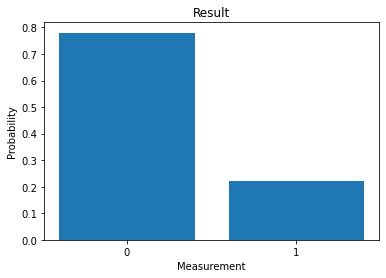

In [308]:
pyplot.bar(result_qpu1.keys(), result_qpu1.values())
pyplot.title("Result")
pyplot.xlabel("Measurement")
_ = pyplot.ylabel("Probability")

The state already had the time to degrade! (high probability of getting the wrong state $|0_L\rangle$).
Can we put more gates to wait a longer time and let the state degrade more?

I couldn't find the correct syntax for jobParams to create a parametrized operation, so I redefine another operation with more in-between "waiting" gates.

In [304]:
%%qsharp

operation PrepareDecayMeasureMedium() : Result {
    use qs = Qubit[4];
    use waitingQubits = Qubit[2];
    PrepareOne_L(qs);
    for _ in 1..1000 {
        TimeWaster(waitingQubits[0], waitingQubits[1]);
    }
    X(qs[1]); //so that One corresponds to logical one.
    return Measure([PauliZ, PauliZ], qs[1..2]);
}

In [305]:
# Set the target to IonQ's QPU
qsharp.azure.target("ionq.qpu")

qpu_job2 = qsharp.azure.submit(PrepareDecayMeasureMedium, shots=100, jobName="PrepareDecayMeas", timeout=2400)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu
Submitting PrepareDecayMeasureMedium to target ionq.qpu...
Job successfully submitted for 100 shots.
   Job name: PrepareDecayMeas
   Job ID: fa932390-d360-467a-b629-54103de20736


In [309]:
qsharp.azure.status(qpu_job2.id)

{'id': 'fa932390-d360-467a-b629-54103de20736', 'name': 'PrepareDecayMeas', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=fa932390-d360-467a-b629-54103de20736', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-04-10T11:16:12.9069163+00:00', 'begin_execution_time': '2022-04-10T11:24:13.281+00:00', 'end_execution_time': '2022-04-10T11:24:58.763+00:00', 'cost_estimate': '$0.00'}

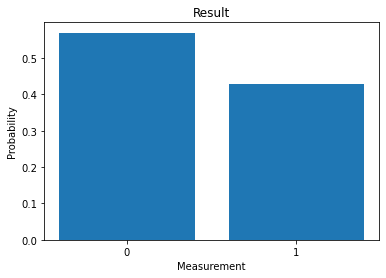

In [310]:
result_qpu2 = qsharp.azure.output(qpu_job2.id)
pyplot.bar(result_qpu2.keys(), result_qpu2.values())
pyplot.title("Result")
pyplot.xlabel("Measurement")
_ = pyplot.ylabel("Probability")

To the opposite of my expectations, it seems the state is requilibrating toward a split 50/50 value. I expected the qubits to decay toward $|0000\rangle$, thus always returning One when measured (as the parity of qubits 2 and 3 in this case is always 0), maybe we are not yet at $t\gg T_2$. To clarify this I would definitely like to plot the final measurement results probabilities as a function of the time waited (that is number of times "TimeWaster" is repeated). Within the time constraint and the long queuing time of the QPU simulator, I'll leave this for another QCHack ;)

We have a single logical qubit that is made of 4 physical ones. If the physical ones are perfect, we can use the logical one without any issue; but as we've seen with the QPU, the noise quickly degrades the encoded state when using real hardware. Let's now see the motivation for using multiple physical qubits.

# Single qubit error Detection

The general idea of quantum error detection (and then correction) in this scheme (and many others!) is to probe the state in a way that will not reveal the actual logical information, but that will tell us if one of the physical qubits made an error. We can achieve this thanks to the redundancy of the information.

## Error detection

In our case, we have special quantum operators, that are called stabilizers, we will write them as $S_i$ where i is an integer to index them. We have for all i $S_i |0_L\rangle=|0_L\rangle$ and $S_i |1_L\rangle=|1_L\rangle$. The eigenvalue is always one. As such, if we measure these operators and find an eigenvalue different than one, we will know that an error occured as it means the physical qubits are not in one of the logical states.
For a single logical qubit encoded in 4 physical qubits, we have a set of 3 stabilizers that can generate all the operators we need (you can multiply any of the three together to get new operators). Let's define their Measurement operators.

In [184]:
%%qsharp

operation MeasureS1(qs : Qubit[]) : Result {
    Rz(2.0*PI(), qs[0]); //Global phase
    return Measure([PauliZ, PauliZ], qs[0..1]);
}

operation MeasureS2(qs : Qubit[]) : Result {
    Rz(2.0*PI(), qs[0]);
    return Measure([PauliZ, PauliZ], qs[2..3]);
}
    
operation MeasureS3(qs : Qubit[]) : Result {
    return Measure([PauliX, PauliX, PauliX, PauliX], qs);
}

Let's test these in a simple simulation:

In [131]:
%%qsharp

operation DetectSingleQubitFlip(qs : Qubit[]) : Bool {
    let resS1 = MeasureS1(qs);
    let resS2 = MeasureS2(qs);
    mutable error = false;
    //any of the two returning zero indicate
    if resS1 == Zero or resS2 == Zero {
        set error = true;
    }
    return error;
}

operation DetectSingleQubitDephase(qs : Qubit[]) : Bool {
    let res = MeasureS3(qs);
    return res == One ? true | false;
}

operation SingleErrorTest(doFlipE : Bool, doPhaseE : Bool) : Unit {
    use qs = Qubit[4];
    PrepareZero_L(qs);
    if doFlipE {
        X(qs[0]); //One qubit flip error
    }
    if doPhaseE {
        Z(qs[1]); //One qubit phase error
    }
    let errorFlip = DetectSingleQubitFlip(qs);
    let errorPhase = DetectSingleQubitDephase(qs);
    if errorFlip {
        Message("Flip error detected!");
    }
    else {
        Message("No flip error detected.");
    }
    if errorPhase {
        Message("Phase error detected!");
    }
    else {
        Message("No phase error detected.");
    }
    DumpMachine();
    ResetAll(qs);
}

In [315]:
SingleErrorTest.simulate(doFlipE=False, doPhaseE=True) #You can try to change the parameters

No flip error detected.
Phase error detected!


|0101⟩	-0,7071067811865479 + 5,423816249231781E-33𝑖
|1010⟩	0,7071067811865479 + -5,423816249231781E-33𝑖

()

We detected erors thanks to the stabilizers. Notice that the measurement operators themselves don't change the logical state.
To correct the error we have to do more measurement to find which qubit to act on.

## Error correction (simplified)

This 2X2 surface code is actually a bit limited, and won't be able to correct all kinds of errors. In our case, we don't have enough stabilizers (and can't get more because of the limited size of our surface code!) to find which qubit is flipped for example. We still want to demonstrate the idea of error correction, so let's try to correct a phase flip under restricted circumstances:

We focus on a single qubit, and assume there is no bit flip (hopefully this will be the case in ion-trap computers where $T_1 \gg T_2$. The qubit is in $|0_L\rangle=(|0101\rangle+|1010\rangle)/\sqrt{2}$ or $|1_L\rangle=(|1001\rangle+|0110\rangle)/\sqrt{2}$ or a superposition of the two. If a single phase error occurs, $|0_L\rangle$ becomes (up to a global phase) $(|0101\rangle-|1010\rangle)/\sqrt{2}$ and $|1_L\rangle$ becomes $(|1001\rangle-|0110\rangle)/\sqrt{2}$. By applying Z gates to the first two physical qubits the error is "corrected". (Notice that if one of these qubits is also flipped because of an other error, it might not work, and the global phase is not corrected).

In [178]:
%%qsharp

operation PhaseErrorSemiCorrection(qs : Qubit[]) : Unit {
    let errDetected = DetectSingleQubitDephase(qs);
    if errDetected {
        Z(qs[0]);
        Z(qs[1]);
    }
}

Let's define two operations where we monitor this $S_3$ stabilizer with and without correction to test our scheme:

In [264]:
%%qsharp

operation CorrTest() : Result {
    use qs = Qubit[4];
    PrepareZero_L(qs);
    for _ in 1..10 {
        //I get FullComputation runtime capability not supported error
        //if I use the previous defined operation "DetectSingleQubitDephase" 
        //(maybe nesting issue?)
        //Here the code is in a single function.
        let res = Measure([PauliX, PauliX, PauliX, PauliX], qs);
        if res==One {
            Z(qs[0]);
            Z(qs[1]);
        }
    }
    //We can't measure in Z basis to see the phase effect!
    //We'll use this X basis measurement to characterize the final state
    let resfinal = Measure([PauliX, PauliX, PauliX, PauliX], qs);
    return resfinal;
}

operation DetectOnlyTest() : Result {
    use qs = Qubit[4];
    PrepareZero_L(qs);
    for _ in 1..10 {
        let res = Measure([PauliX, PauliX, PauliX, PauliX], qs);
    }
    return Measure([PauliX, PauliX, PauliX, PauliX], qs);
}

Note we can't use IonQ targets for this, as if we did, the operation would have to stop just after the measurement, which limits the scheme relevance. (the qubit is no longer usable!)

#### Job submitting to Quantinuum simulator

In [268]:
# Set the target to Quantinuum simulator
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

semiErrorCorrec = qsharp.azure.submit(CorrTest, shots=100, jobName="SemiPhaseCorrection", timeout=2400)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim
Submitting CorrTest to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted for 100 shots.
   Job name: SemiPhaseCorrection
   Job ID: 6ef89328-7581-4c03-ae3a-22dae4ef6b6d


In [272]:
qsharp.azure.status(semiErrorCorrec.id)

{'id': '6ef89328-7581-4c03-ae3a-22dae4ef6b6d', 'name': 'SemiPhaseCorrection', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=6ef89328-7581-4c03-ae3a-22dae4ef6b6d', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-04-10T10:50:33.0400792+00:00', 'begin_execution_time': '2022-04-10T10:52:11.842617+00:00', 'end_execution_time': '2022-04-10T10:52:34.746325+00:00', 'cost_estimate': ''}

In [277]:
semiErrorCorrecRes = qsharp.azure.output(semiErrorCorrec.id)

In [270]:
# Set the target to Quantinuum simulator
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

PhaseDetecJob = qsharp.azure.submit(DetectOnlyTest, shots=100, jobName="PhaseDetection", timeout=2400)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim
Submitting DetectOnlyTest to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted for 100 shots.
   Job name: PhaseDetection
   Job ID: 3b4724f1-ee21-4a87-bb81-fa6d1f0d5e4c


In [274]:
qsharp.azure.status(PhaseDetecJob.id)

{'id': '3b4724f1-ee21-4a87-bb81-fa6d1f0d5e4c', 'name': 'PhaseDetection', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=3b4724f1-ee21-4a87-bb81-fa6d1f0d5e4c', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-04-10T10:51:31.2166385+00:00', 'begin_execution_time': '2022-04-10T10:52:52.513832+00:00', 'end_execution_time': '2022-04-10T10:53:14.352422+00:00', 'cost_estimate': ''}

In [278]:
PhaseDetecRes = qsharp.azure.output(PhaseDetecJob.id)

#### Phase correction results

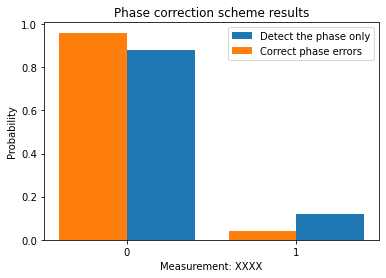

In [318]:
pyplot.bar(PhaseDetecRes.keys(), PhaseDetecRes.values(), align="edge", width=0.4, label="Detect the phase only")
pyplot.bar(semiErrorCorrecRes.keys(), semiErrorCorrecRes.values(), align="edge", width=-0.4, label="Correct phase errors")
pyplot.title("Phase correction scheme results")
pyplot.xlabel("Measurement: XXXX")
pyplot.legend(loc="upper right")
_ = pyplot.ylabel("Probability")

With this quite simple correction scheme, we managed to have less erroneous states (measured as 1 here) at the end of the operation! The measurement is pretty close to 0 (the expected one in errorless environment) at the end, which seems to confirm that we mainly have decoherence effect (rather than decay). Note that the scheme will not correct for two qubits phase erros, and is not really usable in practice due to the global phase too.

# Two logical qubits gate

To actually use this encoding as qubits, we need an entangling two qubit gates. The scheme gets more complicated! The idea is to view the two logical qubits encoded on a 2X2 lattice of qubits as one encoded on a 4X2 lattice. Thanks to two joint measurements, we then project this "merged" qubit onto a state (that will entangle the two initial logical qubits). The merged qubit is finally split again thanks to one last measurement.
All in all, starting from $|0_L0_L\rangle$ and applying the technique, we can end up in the maximally entangled state $|\phi^+\rangle = (|0_L0_L\rangle + |1_L1_L\rangle)/\sqrt{2}$ or in $|\phi^-\rangle = (|0_L0_L\rangle - |1_L1_L\rangle)/\sqrt{2}$ depending on the in-sequence joint measurements results (that are random!).

To get a better visualization, the original author of the scheme view the corresponding operations and their effect on the qubit lattice. The grouping and degrouping of physical qubits are the origin of the name "Lattice Surgery" of this technique.

Writing the operations is less work than it seems, though the underlying quantum computer operations are rather complicated!

In [47]:
%%qsharp

operation MergeJointMeasure (qsA : Qubit[], qsB : Qubit[]) : Result {
    return Measure([PauliX, PauliX, PauliX, PauliX], [qsA[2], qsA[3], qsB[0], qsB[1]]);
}

operation SplitJointMeasureA (qsA : Qubit[], qsB : Qubit[]) : Result {
    return Measure([PauliZ, PauliZ], qsA[0..1]);
}

## Demonstrating entangled state generation

Depending on the in-sequence measurements, we will not get the same state in the end.

Preparing the measurements needed to characterize the final state:

In [49]:
%%qsharp

operation MeasureZAZB (qsA : Qubit[], qsB : Qubit[]) : Result {
    return Measure([PauliZ, PauliZ, PauliZ, PauliZ], [qsA[0], qsA[2], qsB[0], qsB[2]]);
}

operation MeasureXAXB (qsA : Qubit[], qsB : Qubit[]) : Result {
    return Measure([PauliX, PauliX, PauliX, PauliX], [qsA[0], qsA[1], qsB[0], qsB[1]]);
}

operation MeasureYAYB (qsA : Qubit[], qsB : Qubit[]) : Result {
    return Measure([PauliY, PauliX, PauliZ, PauliY, PauliX, PauliZ], [qsA[0], qsA[1], qsA[2], qsB[0], qsB[1], qsB[2]]);
}

In [69]:
%%qsharp

operation GenerateMergedThenSplit_MZZ () : Result[] {
    use qsA = Qubit[4];
    use qsB = Qubit[4];
    //Encode the 00 logical state
    PrepareZero_L(qsA);
    PrepareZero_L(qsB);
    //Use the merge joint measurement to project into the merged basis
    let resM = MergeJointMeasure(qsA, qsB);
    //Split them back into two logical qubits
    let resS = SplitJointMeasureA(qsA, qsB);
    let resZZ = MeasureZAZB(qsA, qsB);
    ResetAll(qsA);
    ResetAll(qsB);
    return [resM, resS, resZZ];
}

operation GenerateMergedThenSplit_MXX () : Result[] {
    use qsA = Qubit[4];
    use qsB = Qubit[4];
    //Encode the 00 logical state
    PrepareZero_L(qsA);
    PrepareZero_L(qsB);
    //Use the merge joint measurement to project into the merged basis
    let resM = MergeJointMeasure(qsA, qsB);
    //Split them back into two logical qubits
    let resS = SplitJointMeasureA(qsA, qsB);
    let resXX = MeasureXAXB(qsA, qsB);
    ResetAll(qsA);
    ResetAll(qsB);
    return [resM, resS, resXX];
}

operation GenerateMergedThenSplit_MYY () : Result[] {
    use qsA = Qubit[4];
    use qsB = Qubit[4];
    //Encode the 00 logical state
    PrepareZero_L(qsA);
    PrepareZero_L(qsB);
    //Use the merge joint measurement to project into the merged basis
    let resM = MergeJointMeasure(qsA, qsB);
    //Split them back into two logical qubits
    let resS = SplitJointMeasureA(qsA, qsB);
    let resYY = MeasureXAXB(qsA, qsB);
    ResetAll(qsA);
    ResetAll(qsB);
    return [resM, resS, resYY];
}

#### Submitting simulation to Quantinuum simulator

Again, there are measurements in-sequence, so we can't use IonQ hardware.

In [52]:
# Set the target to Quantinuum simulator
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

stateGenJobZZ = qsharp.azure.submit(GenerateMergedThenSplit_MZZ, shots=100, jobName="PairGenMeasureZZ", timeout=2400)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim
Submitting GenerateMergedThenSplit to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted for 100 shots.
   Job name: InseqMeasTest
   Job ID: 79cb14ee-d578-4bbf-8945-343eace26b7f


In [64]:
qsharp.azure.status(stateGenJobZZ.id)

{'id': '79cb14ee-d578-4bbf-8945-343eace26b7f', 'name': 'InseqMeasTest', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=79cb14ee-d578-4bbf-8945-343eace26b7f', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-04-10T07:22:39.0504634+00:00', 'begin_execution_time': '2022-04-10T07:23:58.044121+00:00', 'end_execution_time': '2022-04-10T07:23:58.04433+00:00', 'cost_estimate': ''}

In [86]:
resultsZZ = qsharp.azure.output(stateGenJobZZ.id)

In [71]:
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

stateGenJobXX = qsharp.azure.submit(GenerateMergedThenSplit_MXX, shots=100, jobName="PairGenMeasureXX", timeout=2400)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim
Submitting GenerateMergedThenSplit_MXX to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted for 100 shots.
   Job name: PairGenMeasureXX
   Job ID: 8e2a104f-1a6a-46b1-8e48-b6060965bad8


In [77]:
qsharp.azure.status(stateGenJobXX.id)

{'id': '8e2a104f-1a6a-46b1-8e48-b6060965bad8', 'name': 'PairGenMeasureXX', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=8e2a104f-1a6a-46b1-8e48-b6060965bad8', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-04-10T07:29:50.9003487+00:00', 'begin_execution_time': '2022-04-10T07:31:03.925443+00:00', 'end_execution_time': '2022-04-10T07:31:13.539834+00:00', 'cost_estimate': ''}

In [84]:
resultsXX = qsharp.azure.output(stateGenJobXX.id)

In [74]:
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

stateGenJobYY = qsharp.azure.submit(GenerateMergedThenSplit_MYY, shots=100, jobName="PairGenMeasureYY", timeout=2400)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim
Submitting GenerateMergedThenSplit_MYY to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted for 100 shots.
   Job name: PairGenMeasureXX
   Job ID: bf6d204a-9720-4977-86b8-a89f06300a6b


In [88]:
qsharp.azure.status(stateGenJobYY.id)

{'id': 'bf6d204a-9720-4977-86b8-a89f06300a6b', 'name': 'PairGenMeasureXX', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=bf6d204a-9720-4977-86b8-a89f06300a6b', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-04-10T07:30:42.8811933+00:00', 'begin_execution_time': '2022-04-10T07:32:00.619235+00:00', 'end_execution_time': '2022-04-10T07:32:07.890009+00:00', 'cost_estimate': ''}

In [87]:
resultsYY = qsharp.azure.output(stateGenJobYY.id)

#### Results analysis

In [95]:
print(resultsZZ, resultsYY, resultsXX)

{'[1,1,0]': 0.4300000000000002, '[0,1,0]': 0.5100000000000002, '[0,0,0]': 0.01, '[1,0,0]': 0.02, '[1,1,1]': 0.02, '[0,1,1]': 0.01} {'[1,1,1]': 0.4300000000000002, '[0,1,0]': 0.5300000000000002, '[0,0,0]': 0.02, '[1,1,0]': 0.02} {'[1,1,1]': 0.5200000000000002, '[0,0,0]': 0.02, '[1,1,0]': 0.02, '[0,1,0]': 0.4300000000000002, '[0,0,1]': 0.01}


That's messy, where's our state?

Staying in the case where we input $|0_L0_L\rangle$,we can demonstrate that if the in-sequence measurement (merge, split) return (0, 1) then the state generated is $|\phi^+\rangle = (|0_L0_L\rangle + |1_L1_L\rangle)/\sqrt{2}$.
If the in-sequence measurement return (1, 1), then the state generated is $|\phi^-\rangle = (|0_L0_L\rangle - |1_L1_L\rangle)/\sqrt{2}$.
Any other in-sequence measurement means an error occured!

As we can't DumpMachine() the real quantum computer, we have to characterize the state using measurements. We will try to measure the fidelity of our generated $|\psi\rangle$ state $F(|\phi^{\pm}\rangle)=|\langle \psi | \phi^{\pm}\rangle|^2$ (actually what we measure is $|\rho|\phi^{\pm}\rangle|^2$ where $\rho$ is the density matrix of the state we generated, the formalism allows for decoherence and decay, but is more complicated).

We may show that in our case :
$F(|\phi^+\rangle)=\frac{1}{4}(1+\langle Z_L^AZ_L^B\rangle+\langle X_L^AX_L^B\rangle-\langle Y_L^AY_L^B\rangle)$
and
$F(|\phi^-\rangle)=\frac{1}{4}(1+\langle Z_L^AZ_L^B\rangle-\langle X_L^AX_L^B\rangle+\langle Y_L^AY_L^B\rangle)$
where $\langle U \rangle$ is the expectation value of operator $U$.

Let's compare to our results!

In [111]:
def results_to_expectation(results, postselect):
    '''Convert measurement probabilities to expectation values.'''
    zero_res = results.get(f'[{postselect[0]},{postselect[1]},0]')
    one_res = results.get(f'[{postselect[0]},{postselect[1]},1]')
    if zero_res==None:
        zero_res = 0
    if one_res==None:
        one_res = 0
    total_proba = one_res + zero_res
    return (-1*one_res + 1*zero_res)/total_proba
    
def fidelity_phi_minus(resultsZZ, resultsXX, resultsYY):
    ps = [1, 1] #Post-selection depending on in-sequence measurements
    F = (1+results_to_expectation(resultsZZ, ps)
          -results_to_expectation(resultsXX, ps)
          -results_to_expectation(resultsYY, ps))/4
          #the YY minus is here because I forgot a complex i
          #in the YY measurement, hence inverting value! 
    return F  

def fidelity_phi_plus(resultsZZ, resultsXX, resultsYY):
    ps = [0, 1] #Post-selection depending on in-sequence measurements
    F = (1+results_to_expectation(resultsZZ, ps)
          +results_to_expectation(resultsXX, ps)
          +results_to_expectation(resultsYY, ps))/4
    return F

In [113]:
fidelity_phi_plus(resultsZZ, resultsXX, resultsYY)

0.9903846153846154

In [114]:
fidelity_phi_minus(resultsZZ, resultsXX, resultsYY)

0.937037037037037

This is great (maybe surprisingly high)! Do notice we did not do any error correction in this two entangled state generation. We also artificially improved the fidelity of the state we got thanks to the post-selection we did. If we took results which had (0,0) or (1,0) in-sequence measurements, the final state would have had an error for sure, which would have decreased the fidelity!

# Summary

In this notebook, we explored a small version of surface code. We encoded logical information into it, and defined single qubit operations. We observed how the state decays and decoheres on real hardware, and how this can be mitigated in a simplified error correction scheme. Finally, we implemented one version of the lattice surgery technique so as to complete the capabilities of our logical qubit, allowing it to be entangled with other logical qubits. While interesting and insightful, the scheme needs to be extended to be able to correct all errors, and finally help achieve a fault-tolerant quantum computer.